In [2]:
# This is just a scratch cell for pip install commands
%pip install scikit-image

     ---------------------------------------- 0.0/24.5 MB ? eta -:--:--
     ---------------------------------------- 0.1/24.5 MB 2.4 MB/s eta 0:00:10
      --------------------------------------- 0.4/24.5 MB 4.3 MB/s eta 0:00:06
     - -------------------------------------- 0.7/24.5 MB 4.6 MB/s eta 0:00:06
     - -------------------------------------- 0.9/24.5 MB 4.8 MB/s eta 0:00:05
     - -------------------------------------- 1.1/24.5 MB 4.7 MB/s eta 0:00:05
     -- ------------------------------------- 1.3/24.5 MB 4.7 MB/s eta 0:00:05
     -- ------------------------------------- 1.6/24.5 MB 5.0 MB/s eta 0:00:05
     --- ------------------------------------ 1.9/24.5 MB 5.1 MB/s eta 0:00:05
     --- ------------------------------------ 2.4/24.5 MB 5.6 MB/s eta 0:00:04
     ---- ----------------------------------- 2.7/24.5 MB 5.8 MB/s eta 0:00:04
     ----- ---------------------------------- 3.2/24.5 MB 6.3 MB/s eta 0:00:04
     ------ --------------------------------- 3.7/24.5 MB 6

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.

[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [24]:
import numpy as np
import pandas as pd
import seaborn as sns
import pickle
import matplotlib.pyplot as plt
from textwrap import wrap
from skimage import exposure, color

import os
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from sklearn.utils import resample
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
# Loading labels.csv

label_key = pd.read_csv('labels.csv')

In [3]:
print(label_key)

    ClassId                          Name
0         0           Speed limit (5km/h)
1         1          Speed limit (15km/h)
2         2          Speed limit (30km/h)
3         3          Speed limit (40km/h)
4         4          Speed limit (50km/h)
5         5          Speed limit (60km/h)
6         6          Speed limit (70km/h)
7         7          speed limit (80km/h)
8         8      Dont Go straight or left
9         9     Dont Go straight or Right
10       10              Dont Go straight
11       11                  Dont Go Left
12       12         Dont Go Left or Right
13       13                 Dont Go Right
14       14       Dont overtake from Left
15       15                      No Uturn
16       16                        No Car
17       17                       No horn
18       18          Speed limit (40km/h)
19       19          Speed limit (50km/h)
20       20          Go straight or right
21       21                   Go straight
22       22                       

In [4]:
# Defining an ImageDatGenerator 
# This is used to homogenize image data for conversion to array
# This can also be used to augment data
# Currently, only used to normalize values between 0.0 and 1.0

test_datagen = ImageDataGenerator(
    rescale=1.0/255.0
)

train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize the images to [0, 1]
    rotation_range=20,  # Randomly rotate images in the range (degrees, 0 to 20)
    width_shift_range=0.2,  # Randomly horizontal shift images
    height_shift_range=0.2,  # Randomly vertical shift images
)


In [5]:
# Defining indices of unknowns

unknowns = [40,41,42,45,49,52,56,57]

In [6]:
# Loading training images and label data
# Using flow_from_directory function of the above ImageDataGenerator object
# Currently working on batches of 64, with no shuffling.
# Fixing output image size to 256x256

train_path = 'traffic_Data/DATA/'
trn_img_arr_list = []
trn_label_arr_list = []

img_itr = datagen.flow_from_directory(
    directory=train_path,
    target_size=(128,128),
    shuffle=False,
    batch_size = 1
)

# Going through the dictionary iterable returned by the above function

for i in  range(len(img_itr)):
  img, label = img_itr[i]
  if not np.any(label[:,unknowns] == 1):
    trn_img_arr_list.append(img)
    trn_label_arr_list.append(label)
  

# Converting the lists to numpy arrays
# And printing their shape to check dimensions

trn_img_arr = np.concatenate(trn_img_arr_list, axis=0)
trn_label_arr = np.concatenate(trn_label_arr_list, axis=0)
print("Training Image Array dimensions: ",trn_img_arr.shape)
print("Training Labels Array dimensions: ",trn_label_arr.shape)

# From the output of the above print statements, we see:
# Training image array is 4170x256x256x3
# Label array is 4170x58
# Thus, there are 4170 training images, each of size 256x256, and 3 colour channels
# The labels are also one-hot encoded

# Note: ImageDataGenerator.flow_from_directory expects image data to be organized as such:
# Images are to be organized into subfolders based on label
# The name of each subfolder is taken as the label name
# Fortunately, our data is already structured as required

Found 4170 images belonging to 58 classes.
Training Image Array dimensions:  (3800, 128, 128, 3)
Training Labels Array dimensions:  (3800, 58)


In [7]:
# Loading test images and label data
# The process is identical to the previous cell

test_path = 'traffic_Data/TEST_STRUCTURED'
tst_img_arr_list = []
tst_label_arr_list = []


img_itr = datagen.flow_from_directory(
    directory=test_path,
    target_size=(128,128),
    shuffle=False,
    batch_size = 1
)

for i in  range(len(img_itr)):
  img, label = img_itr[i]
  if not np.any(label[:,unknowns] == 1):
    tst_img_arr_list.append(img)
    tst_label_arr_list.append(label)

tst_img_arr = np.concatenate(tst_img_arr_list, axis=0)
tst_label_arr = np.concatenate(tst_label_arr_list, axis=0)
print("Training Image Array dimensions: ",tst_img_arr.shape)
print("Training Labels Array dimensions: ",tst_label_arr.shape)

# According to the print statements, we see:
# Test Image Array dimensions: 1994x256x256x3
# Test Labels Array dimensions: 1994x58
# Thus, there are 1994 test images, each of size 256x256, with 3 colour channels
# The labels are also one-hot encoded

# test set missing class 9, 18, 19, 33

Found 1998 images belonging to 58 classes.
Training Image Array dimensions:  (1865, 128, 128, 3)
Training Labels Array dimensions:  (1865, 58)


Visualizing Data

In [8]:
# Defining a function to create a bar plot for class distribution
# Called twice, once for training set and once for test set

def class_balance_plot(x, y, bar_width=0.5, title="Title"):
    plt.figure(figsize=(10,10))
    plt.bar(x, y, width=bar_width)
    plt.xlabel('Class Label')
    plt.ylabel('Frequency')
    plt.xticks(rotation=90, ha='center')
    plt.title(title)
    plt.tight_layout()

    return plt.gca()

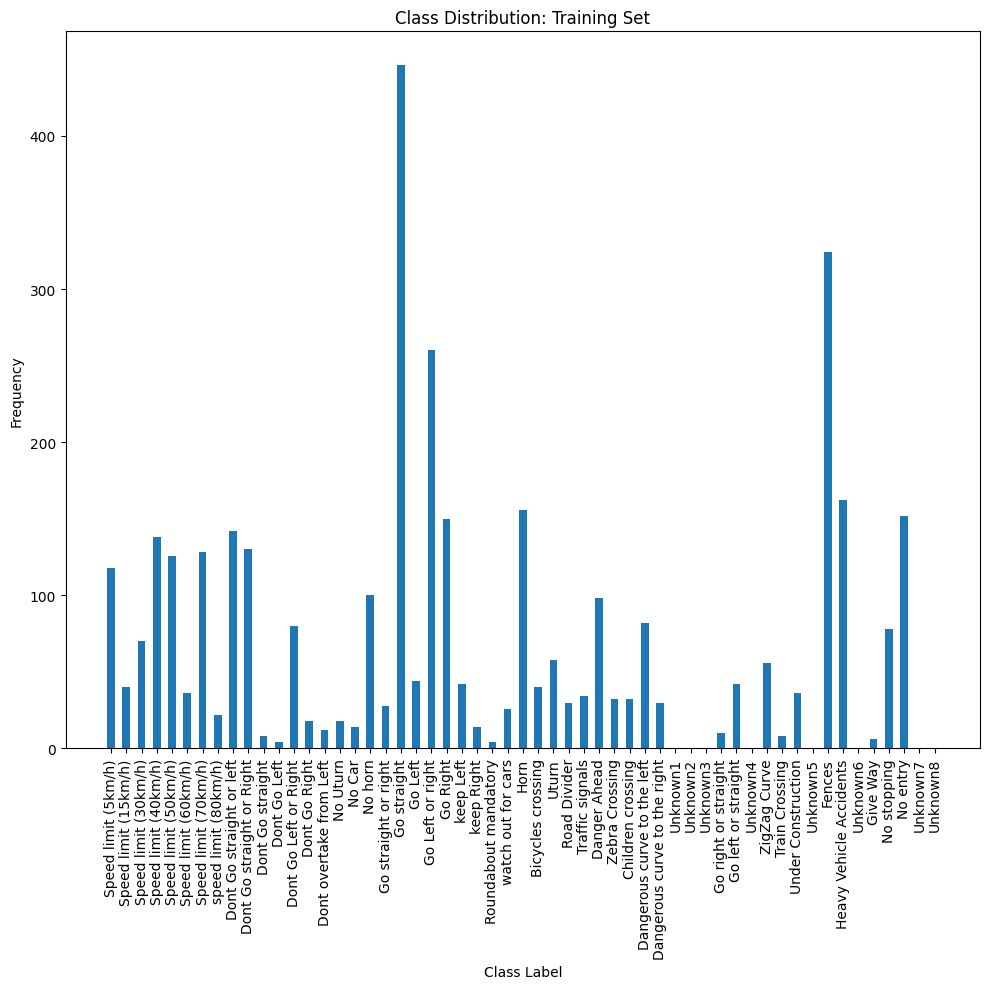

In [9]:
# Visualising class balance in training set

class_names = label_key['Name'].values
trn_class_count = np.sum(trn_label_arr, axis=0)
trn_chart = class_balance_plot(class_names, trn_class_count, title="Class Distribution: Training Set")
plt.show()

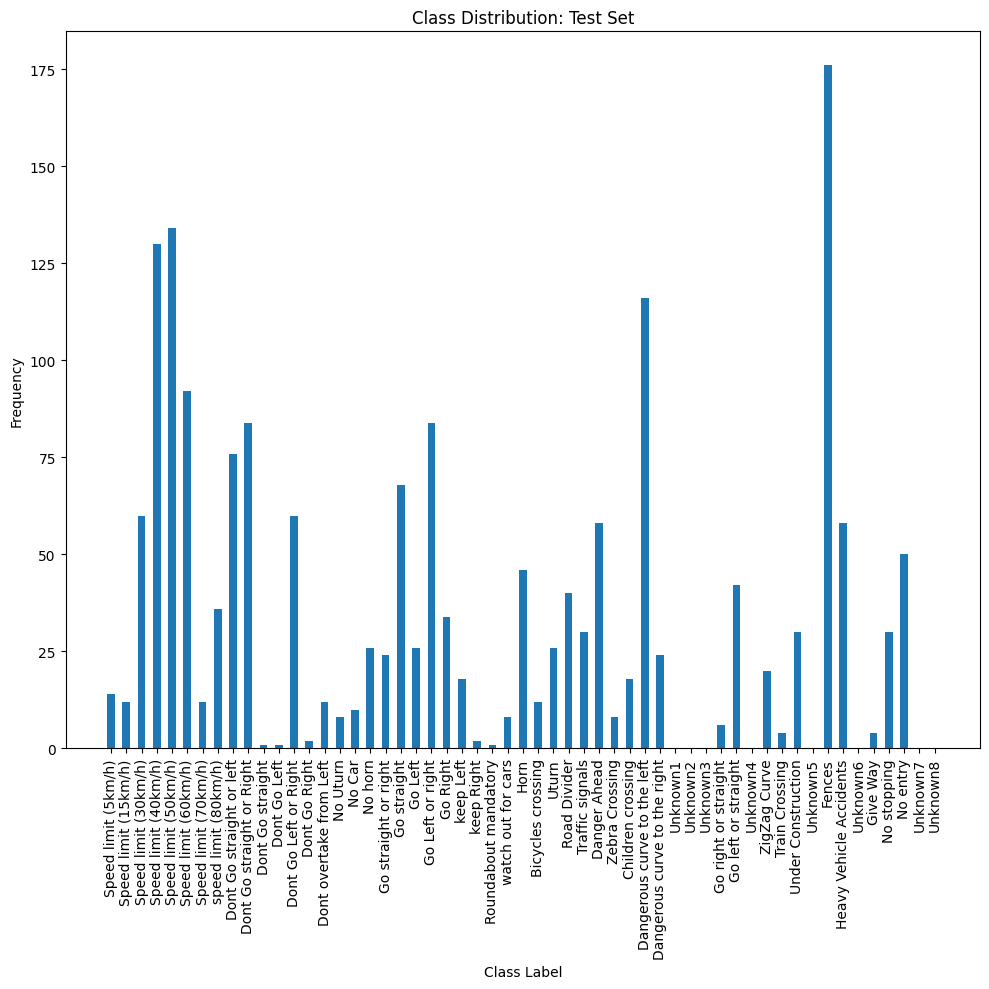

In [10]:
# Visualizing class balance in test set

class_names = label_key['Name'].values
tst_class_count = np.sum(tst_label_arr, axis=0)
trn_chart = class_balance_plot(class_names, tst_class_count, title="Class Distribution: Test Set")
plt.show()

Addressing Imbalance in Training Set

In [11]:
# Removing Unknown classes
# from label arrays
# NOT needed to be removed from image arrays
# since unknown images weren't added to the accumulator lists in the first place
array_2d = np.random.random((3800, 58))

# Create a boolean mask for columns to keep
mask = np.ones(array_2d.shape[1], dtype=bool)
mask[unknowns] = False

# Apply the mask to remove columns
trn_label_arr_masked = trn_label_arr[:, mask]
tst_label_arr_masked = tst_label_arr[:,mask]

print("Original Train label array shape:", trn_label_arr.shape)
print("Shape after removing unknown columns:", trn_label_arr_masked.shape)

print("Original Test label array shape:", tst_label_arr.shape)
print("Shape after removing unknown columns:", tst_label_arr_masked.shape)

# Removing corresponding elements from class_count arrays
trn_class_count_masked = trn_class_count[mask]
tst_class_count_masked = tst_class_count[mask]

# Removing corresponding class names
class_names_masked = class_names[mask]

Original Train label array shape: (3800, 58)
Shape after removing unknown columns: (3800, 50)
Original Test label array shape: (1865, 58)
Shape after removing unknown columns: (1865, 50)


In [12]:
# Defining thresholds for demarcating minority, average, and majority classes
# based on mean, not percentiles
# Adjust as needed

min_thres = np.mean(trn_class_count_masked) 
maj_thres = np.mean(trn_class_count_masked) 

# Getting indices of the minority and majority classes
# based on above-defined thresholds

minority_classes_idx = np.squeeze(np.array(np.where(trn_class_count_masked < min_thres)))
print("Indexes of minority classes:",minority_classes_idx)
majority_classes_idx = np.squeeze(np.array(np.where(trn_class_count_masked >= maj_thres)))
print("Indexes of majority classes",majority_classes_idx)



Indexes of minority classes: [ 1  2  5  7 10 11 13 14 15 16 18 20 22 25 26 27 28 30 31 32 33 35 36 37
 39 40 41 42 43 44 47]
Indexes of majority classes [ 0  3  4  6  8  9 12 17 19 21 23 24 29 34 38 45 46 48 49]


In [13]:
# Trying Under/Oversampling:
# Oversample small classes and Undersample large classes

# Defining accumulator lists
upsample_img = []
upsample_label = []
downsample_img = []
downsample_label = []


for idx in minority_classes_idx:
    min_img_rows = trn_label_arr_masked[:,idx]
    min_img_arr = trn_img_arr[min_img_rows == 1, :, :,:]
    
    upsample_batch = resample(min_img_arr,
                            replace=True,
                            n_samples=int(np.mean(trn_class_count_masked)))
    
    label_temp = np.zeros((len(upsample_batch), len(trn_class_count_masked)))
    label_temp[:,idx] = 1

    upsample_img.append(upsample_batch)
    upsample_label.append(label_temp)

upsample_img = np.concatenate(upsample_img, axis=0)
print("Shape of upsampled image array:",upsample_img.shape)
upsample_label = np.concatenate(upsample_label, axis=0)
print("Shape of upsampled label array:",upsample_label.shape)

for idx in majority_classes_idx:
    maj_img_rows = trn_label_arr_masked[:,idx]
    maj_img_arr = trn_img_arr[maj_img_rows == 1, :, :,:]
    
    downsample_batch = resample(maj_img_arr,
                            replace=True,
                            n_samples=int(np.mean(trn_class_count_masked)))
    
    label_temp = np.zeros((len(downsample_batch), len(trn_class_count_masked)))
    label_temp[:,idx] = 1

    downsample_img.append(downsample_batch)
    downsample_label.append(label_temp)

downsample_img = np.concatenate(downsample_img, axis=0)
print("Shape of downsampled image array:",downsample_img.shape)
downsample_label = np.concatenate(downsample_label, axis=0)
print("Shape of downsampled label array:",downsample_label.shape)

    


Shape of upsampled image array: (2356, 128, 128, 3)
Shape of upsampled label array: (2356, 50)
Shape of downsampled image array: (1444, 128, 128, 3)
Shape of downsampled label array: (1444, 50)


Shape of equalized image array:  (3800, 128, 128, 3)
Shape of equalized label array:  (3800, 50)


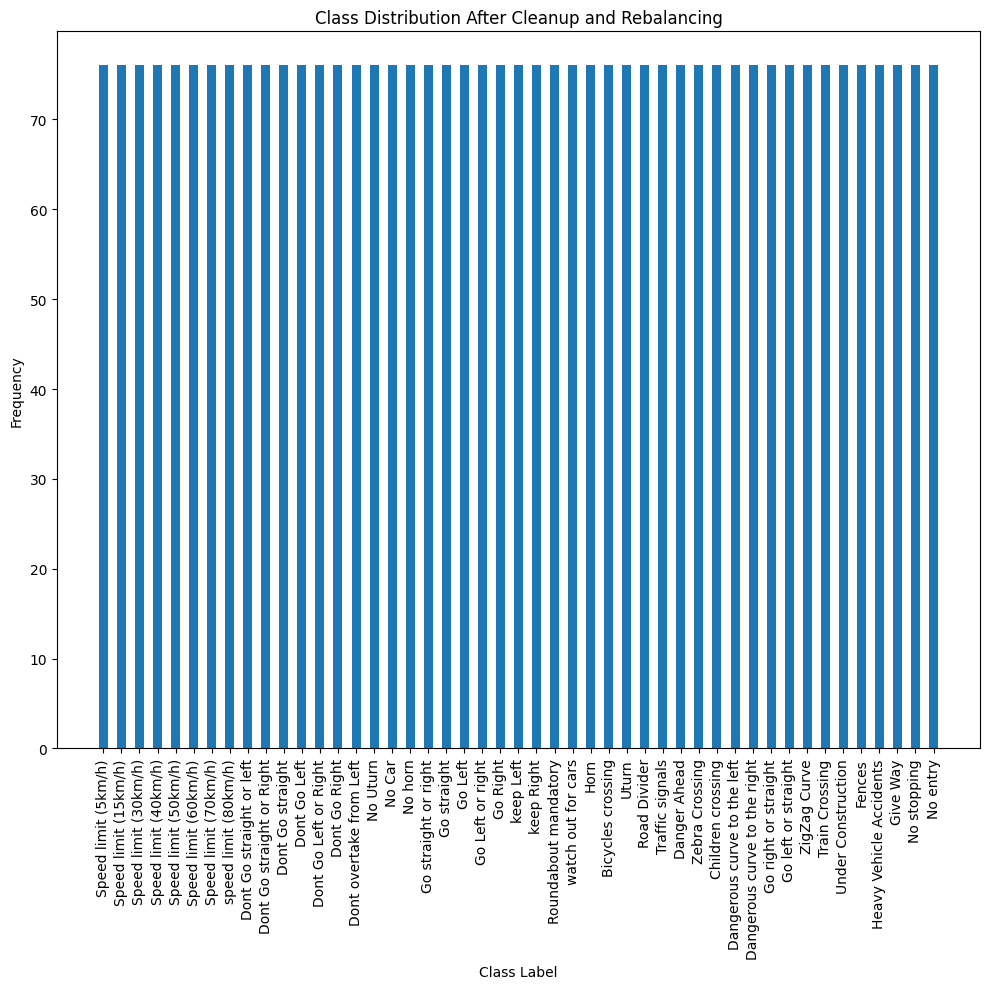

In [15]:
# Joining the upsampled and downsampled sets
# Getting the class distribution of equalized classes
# Checking the shape of the new balanced set
trn_img_arr_eql = np.concatenate((upsample_img, downsample_img), axis=0)
trn_label_arr_eql = np.concatenate((upsample_label, downsample_label), axis=0)

class_count_eql = trn_label_arr_eql.sum(axis=0)
print("Shape of equalized image array: ",trn_img_arr_eql.shape)
print("Shape of equalized label array: ",trn_label_arr_eql.shape)

equalized_distribution = class_balance_plot(class_names_masked, class_count_eql, title="Class Distribution After Cleanup and Rebalancing")
plt.show()

As we can see from the above graph, the classes are cleaned up and balanced

In [16]:
# Splitting validation set off from training set

trn_img_arr_final, val_img_arr, trn_label_arr_final, val_label_arr = train_test_split(trn_img_arr_eql, trn_label_arr_eql, test_size=0.2, random_state=42)
print("Shape of training image array: ", trn_img_arr_final.shape)
print("Shape of training label array: ", trn_label_arr_final.shape)
print("Shape of validation image array: ", val_img_arr.shape)
print("Shape of validation label array: ", val_label_arr.shape)

Shape of training image array:  (3040, 128, 128, 3)
Shape of training label array:  (3040, 50)
Shape of validation image array:  (760, 128, 128, 3)
Shape of validation label array:  (760, 50)


In [90]:
# Data augmentation for the CNN model

train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize the images to [0, 1]
    rotation_range=20,  # Randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=0.2,  # Randomly horizontal shift images
    height_shift_range=0.2,  # Randomly vertical shift images
    horizontal_flip=False,  # Randomly flip images horizontally
)

In [111]:
trn_generator = train_datagen.flow(
    trn_img_arr_final,
    trn_label_arr_final,
    batch_size=100
)

val_generator = train_datagen.flow(
    val_img_arr,
    val_label_arr,
    batch_size=100
)

In [17]:
# Creating initial CNN model

model = Sequential([
    # Convolutional layer with 32 filters, kernel size of 3x3, activation function ReLU
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D(2, 2),

    # Another convolutional layer with 64 filters
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    # Another convolutional layer with 128 filters
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    # Flatten the output of the convolutional layers
    Flatten(),

    # Dense layer with 512 units and ReLU activation
    Dense(512, activation='relu'),

    # Dropout layer to reduce overfitting
    Dropout(0.5),

    # Output layer with units equal to the number of classes and softmax activation
    Dense(50, activation='softmax')
])

# Display the model's architecture
model.summary()

c:\Users\mdoma\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    12,845,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 50)             │        25,650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,964,466 (49.46 MB)

 Trainable params: 12,964,466 (49.46 MB)

 Non-trainable params: 0 (0.00 B)

In [18]:
# Initial untuned compilation of CNN Model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [20]:
history = model.fit(
    x=trn_img_arr_final,
    y=trn_label_arr_final,
    #steps_per_epoch=len(trn_img_arr_final) // trn_generator.batch_size,
    validation_data=(val_img_arr, val_label_arr),
    #validation_steps=len(val_img_arr)// val_generator.batch_size,
    epochs=10  # Number of epochs to train for
)

Epoch 1/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 38s 363ms/step - accuracy: 0.1764 - loss: 3.3103 - val_accuracy: 0.8961 - val_loss: 0.4861
Epoch 2/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 32s 337ms/step - accuracy: 0.8703 - loss: 0.4654 - val_accuracy: 0.9711 - val_loss: 0.1463
Epoch 3/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 33s 346ms/step - accuracy: 0.9724 - loss: 0.1109 - val_accuracy: 0.9868 - val_loss: 0.0603
Epoch 4/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 33s 344ms/step - accuracy: 0.9848 - loss: 0.0556 - val_accuracy: 0.9829 - val_loss: 0.0757
Epoch 5/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 33s 344ms/step - accuracy: 0.9885 - loss: 0.0546 - val_accuracy: 0.9829 - val_loss: 0.0685
Epoch 6/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 33s 344ms/step - accuracy: 0.9861 - loss: 0.0459 - val_accuracy: 0.9855 - val_loss: 0.0629
Epoch 7/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 33s 342ms/step - accuracy: 0.9826 - loss: 0.0660 - val_accuracy: 0.9934 - val_loss: 0.0450
Epoch 8/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 32s 339ms/step - accuracy: 0.9963 - loss: 0.0136 - val_accu

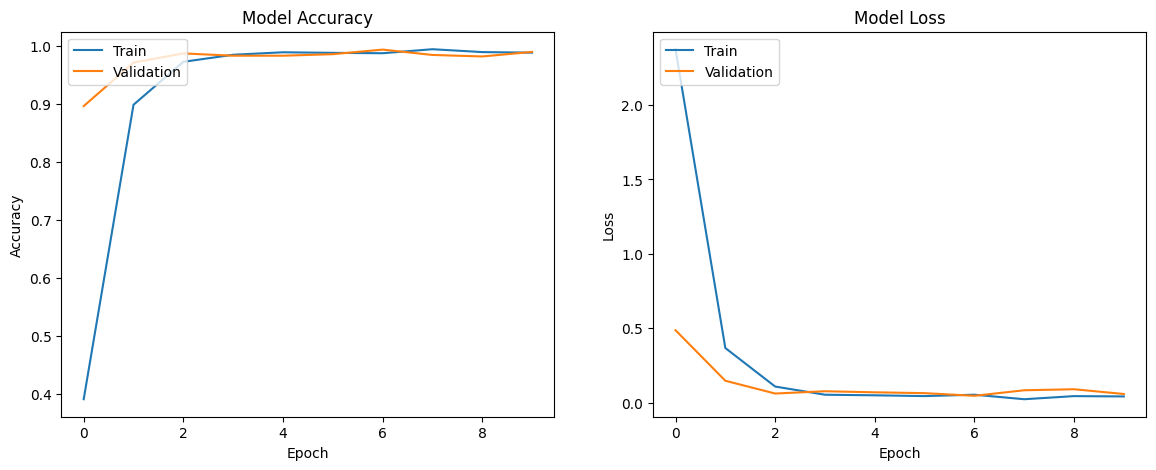

In [21]:
# Plot training & validation accuracy values
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

plt.show()

Hyperparameter Tuning

Training with Adam optimizer


c:\Users\mdoma\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/15
95/95 ━━━━━━━━━━━━━━━━━━━━ 41s 372ms/step - accuracy: 0.0902 - loss: 3.7498 - val_accuracy: 0.5500 - val_loss: 2.2847
Epoch 2/15
95/95 ━━━━━━━━━━━━━━━━━━━━ 32s 334ms/step - accuracy: 0.5062 - loss: 1.9694 - val_accuracy: 0.8421 - val_loss: 0.7611
Epoch 3/15
95/95 ━━━━━━━━━━━━━━━━━━━━ 31s 325ms/step - accuracy: 0.7963 - loss: 0.8135 - val_accuracy: 0.9408 - val_loss: 0.3432
Epoch 4/15
95/95 ━━━━━━━━━━━━━━━━━━━━ 31s 328ms/step - accuracy: 0.9204 - loss: 0.3555 - val_accuracy: 0.9697 - val_loss: 0.1901
Epoch 5/15
95/95 ━━━━━━━━━━━━━━━━━━━━ 32s 333ms/step - accuracy: 0.9414 - loss: 0.2230 - val_accuracy: 0.9697 - val_loss: 0.1284
Epoch 6/15
95/95 ━━━━━━━━━━━━━━━━━━━━ 32s 331ms/step - accuracy: 0.9673 - loss: 0.1335 - val_accuracy: 0.9789 - val_loss: 0.0970
Epoch 7/15
95/95 ━━━━━━━━━━━━━━━━━━━━ 32s 331ms/step - accuracy: 0.9833 - loss: 0.0894 - val_accuracy: 0.9829 - val_loss: 0.0814
Epoch 8/15
95/95 ━━━━━━━━━━━━━━━━━━━━ 32s 335ms/step - accuracy: 0.9883 - loss: 0.0640 - val_accu

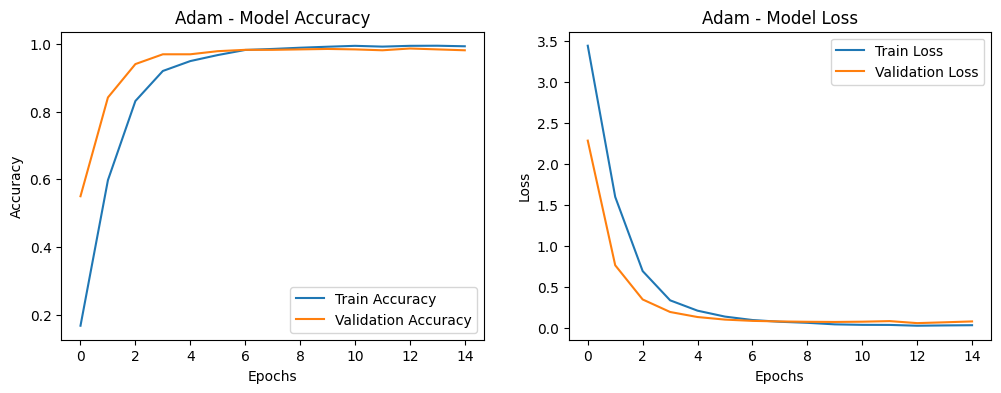

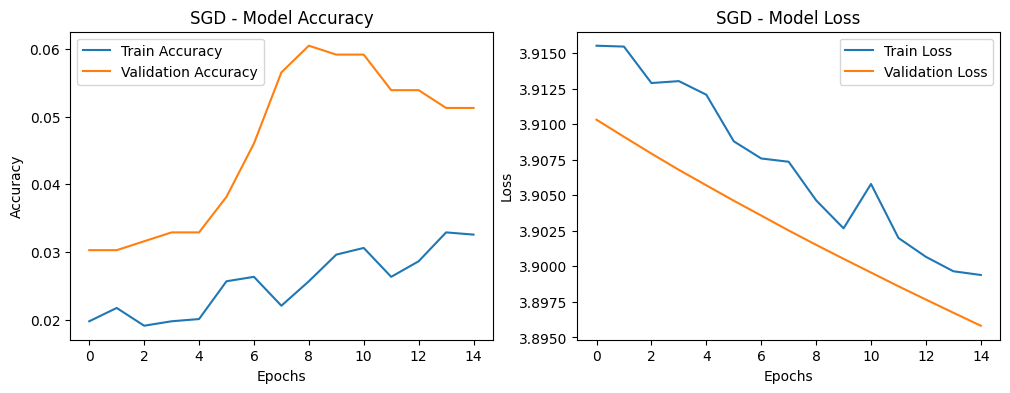

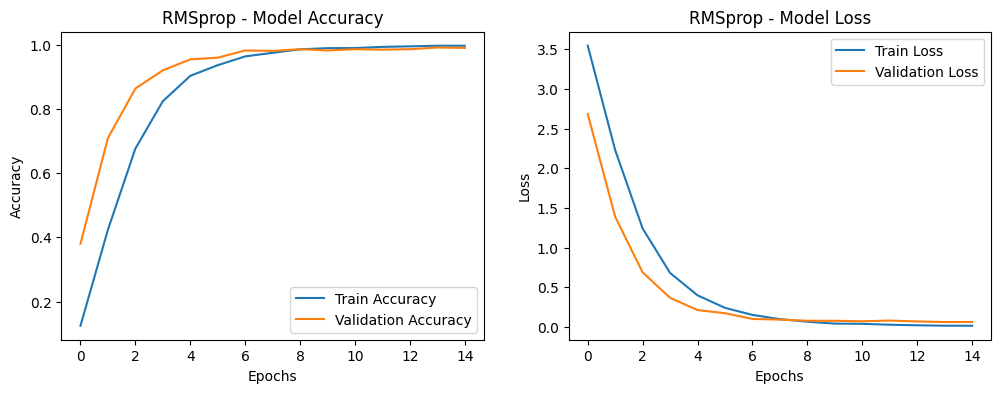

In [23]:
# Defining optimizer

def create_model(optimizer):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
        MaxPooling2D(2, 2),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(50, activation='softmax')
    ])

    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Train and evaluate the model using different optimizers
results = {}
optimizers = {
    'Adam': Adam(learning_rate=1e-4),
    'SGD': SGD(learning_rate=1e-4),
    'RMSprop': RMSprop(learning_rate=1e-4)
}

for name, optimizer in optimizers.items():
    print(f"Training with {name} optimizer")
    model = create_model(optimizer)
    history = model.fit(
        x=trn_img_arr_final,
        y=trn_label_arr_final,
        #steps_per_epoch=train_generator.samples // train_generator.batch_size,
        epochs=15,
        validation_data=(val_img_arr, val_label_arr),
        #validation_steps=validation_generator.samples // validation_generator.batch_size
    )

    # Save the results
    results[name] = {
        'accuracy': history.history['accuracy'],
        'val_accuracy': history.history['val_accuracy'],
        'loss': history.history['loss'],
        'val_loss': history.history['val_loss']
    }

# Compare the results
for name in optimizers.keys():
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(results[name]['accuracy'], label='Train Accuracy')
    plt.plot(results[name]['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{name} - Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(results[name]['loss'], label='Train Loss')
    plt.plot(results[name]['val_loss'], label='Validation Loss')
    plt.title(f'{name} - Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

Using the tuned model and testing

In [35]:
# Defining tuned model
model_tuned = create_model(optimizer="RMSprop")

# Training the model to data
model_tuned.fit(
    x=trn_img_arr_final,
    y=trn_label_arr_final,
    epochs=15,
    validation_data=(val_img_arr, val_label_arr),
)



c:\Users\mdoma\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/15
95/95 ━━━━━━━━━━━━━━━━━━━━ 33s 308ms/step - accuracy: 0.1334 - loss: 3.7196 - val_accuracy: 0.7618 - val_loss: 0.8895
Epoch 2/15
95/95 ━━━━━━━━━━━━━━━━━━━━ 26s 273ms/step - accuracy: 0.7801 - loss: 0.7847 - val_accuracy: 0.9276 - val_loss: 0.2806
Epoch 3/15
95/95 ━━━━━━━━━━━━━━━━━━━━ 25s 260ms/step - accuracy: 0.9437 - loss: 0.2034 - val_accuracy: 0.9776 - val_loss: 0.0795
Epoch 4/15
95/95 ━━━━━━━━━━━━━━━━━━━━ 25s 264ms/step - accuracy: 0.9612 - loss: 0.1204 - val_accuracy: 0.9882 - val_loss: 0.0663
Epoch 5/15
95/95 ━━━━━━━━━━━━━━━━━━━━ 25s 260ms/step - accuracy: 0.9786 - loss: 0.0632 - val_accuracy: 0.9842 - val_loss: 0.0827
Epoch 6/15
95/95 ━━━━━━━━━━━━━━━━━━━━ 25s 259ms/step - accuracy: 0.9867 - loss: 0.0406 - val_accuracy: 0.9868 - val_loss: 0.0744
Epoch 7/15
95/95 ━━━━━━━━━━━━━━━━━━━━ 29s 302ms/step - accuracy: 0.9942 - loss: 0.0260 - val_accuracy: 0.9816 - val_loss: 0.1005
Epoch 8/15
95/95 ━━━━━━━━━━━━━━━━━━━━ 26s 274ms/step - accuracy: 0.9920 - loss: 0.0200 - val_accu

In [37]:
# Testing the model
predictions = model_tuned.predict(tst_img_arr)
print(predictions.shape)
print(tst_label_arr_masked.shape)

predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(tst_label_arr_masked, axis=1)
print(predicted_labels)
print(true_labels)
print(classification_report(predicted_labels, true_labels))

59/59 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step
(1865, 50)
(1865, 50)
[37  0 34 ... 12 49 12]
[ 0  0  0 ... 49 49 49]
              precision    recall  f1-score   support

           0       0.71      0.22      0.33        46
           1       0.67      0.57      0.62        14
           2       0.93      0.85      0.89        66
           3       0.72      0.98      0.83        96
           4       1.00      0.50      0.67        44
           5       0.80      0.76      0.78        98
           6       0.33      0.50      0.40         8
           7       0.22      0.50      0.31        16
           8       0.87      0.72      0.79        92
           9       0.69      0.97      0.81        60
          10       1.00      0.33      0.50         3
          11       1.00      0.03      0.07        29
          12       0.83      0.45      0.59       110
          13       1.00      0.33      0.50         6
          14       0.83      1.00      0.91        10
          15       1.00  

Conclusion:

As we see from the above results, the overall accuracy of the model is 68%.
Moreover, we see that classes 27, 40, and 44 have an f1-score of 1.00, and many others have an f1-score of more than 0.9.

With this, we can assume that due to the heavily imbalanced nature of the dataset, even our attempts to rebalance it could only do so much. Quite a few classes in the dataset have only a handful of images. This extreme imbalance may be too much to try and rectify by resampling. 

Additionally, the CNN models cannot make predictions in real-time.

With this, we can start using the LISA dataset, and more sophisticated approaches in traffic-sign-classification-cnn-official.ipynb